In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as TF

import pandas as pd
import numpy as np
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for dataset

transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = ImageFolder(root='/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/mvtec2/train', transform=transform)
val_dataset = ImageFolder(root='/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/mvtec2/val', transform=transform)
test_dataset = ImageFolder(root='/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/mvtec2/test', transform=transform)

# Class mapping
class_map = {i: train_dataset.classes[i] for i in range(len(train_dataset.classes))}

/home/iai/anaconda3/envs/jwanaconda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

2588
862
862


In [3]:
# Define ResNet model
class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=True)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)

        x = self.resnet18.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train(model, optimizer, criterion, labeled_loader):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total = 0
    for images, labels in labeled_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_acc += (predicted == labels).sum().item()
    train_loss /= len(labeled_loader)
    train_acc /= total
    return train_loss, train_acc

In [4]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=4, verbose=False, delta=0, path='checkpoint.pt', min_epoch = 0, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.epoch = 0
        self.min_epoch = min_epoch
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss
        self.epoch +=1
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            
            if self.epoch < self.min_epoch:
                self.counter = 0
                self.trace_func("Not enough epoch")
            else:
                self.counter += 1
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [22]:
# Cutpaste
def apply_cutpaste(image):
    """
    Applies Cut-and-Paste data augmentation to an input image.

    Args:
    - image (torch.Tensor): input image tensor of shape (C, H, W).

    Returns:
    - augmented_image (Image.Image): cut-and-paste augmented image.
    """
    # Convert image to numpy array
    image_np = image.permute(1, 2, 0).numpy()

    # Generate random patch size
    patch_width = np.random.randint(int(min(image_np.shape[:2]) * 0.15), int(min(image_np.shape[:2]) * 0.5))
    patch_height = np.random.randint(int(min(image_np.shape[:2]) * 0.15), int(min(image_np.shape[:2]) * 0.5))
    patch_size = (patch_width, patch_height)

    # Generate random patch position
    center_x, center_y = np.random.randint(patch_size[0], image_np.shape[0] - patch_size[0]), np.random.randint(patch_size[1], image_np.shape[1] - patch_size[1])

    # Generate random crop positions for image
    crop_x_min, crop_x_max = center_x - patch_size[0], center_x + patch_size[0]
    crop_y_min, crop_y_max = center_y - patch_size[1], center_y + patch_size[1]

    # Crop image
    image_crop = image_np[crop_x_min:crop_x_max, crop_y_min:crop_y_max]

    # Generate random paste position
    paste_x, paste_y = np.random.randint(patch_size[0], image_np.shape[0] - patch_size[0]), np.random.randint(patch_size[1], image_np.shape[1] - patch_size[1])

    # Paste cropped image onto image
    image_paste = image_np.copy()
    image_paste[paste_x-patch_size[0]:paste_x+patch_size[0], paste_y-patch_size[1]:paste_y+patch_size[1]] = image_crop

    # Convert image back to torch tensor
    augmented_image = TF.to_tensor(image_paste).permute(1, 2, 0)
    augmented_image = (augmented_image.numpy() * 255).astype(np.uint8)
    augmented_image = Image.fromarray(augmented_image)

    return augmented_image



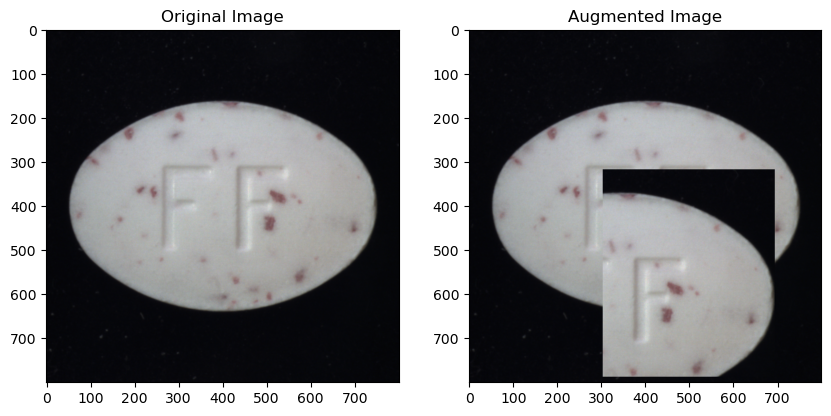

In [37]:
# import torch
# import numpy as np
# import torchvision.transforms.functional as TF
# from PIL import Image
# import matplotlib.pyplot as plt

# # Load example image
# image_path = '/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/mvtec2/test/good/pill (185).png'
# image = Image.open(image_path)

# # Convert image to tensor
# image_tensor = TF.to_tensor(image)

# # Apply cut-and-paste data augmentation
# augmented_image = apply_cutpaste(image_tensor)

# # Plot original and augmented images side by side
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(image)
# ax[0].set_title('Original Image')
# ax[1].imshow(augmented_image)
# ax[1].set_title('Augmented Image')
# plt.show()


In [29]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

test_loss_unc = []
test_acc_unc = []
test_auc_score_unc = []
test_roc_auc_unc = []
test_precision_unc = []
test_recall_unc = []
test_f1_unc = []

df_unc2 = pd.DataFrame(columns = train_dataset.classes)

num_initial_samples = 100
batch_size = 128

# Define initial labeled dataset
labeled_indices_unc = torch.randperm(len(train_dataset))[:num_initial_samples]
labeled_dataset_unc = torch.utils.data.Subset(train_dataset, labeled_indices_unc)

unlabeled_indices_unc = torch.arange(len(train_dataset))[~torch.eq(torch.arange(len(train_dataset)).unsqueeze(1), labeled_indices_unc).any(1)]
unlabeled_dataset_unc = torch.utils.data.Subset(train_dataset, unlabeled_indices_unc)

# Define data loaders
labeled_loader_unc = DataLoader(labeled_dataset_unc, batch_size=128, shuffle=True)
unlabeled_loader_unc = DataLoader(unlabeled_dataset_unc, batch_size=128, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [7]:
def class_count(dataset):
    """
    Returns the count of normal and anomaly classes in a labeled dataset.

    Args:
    - dataset (list): labeled dataset where each element is a tuple (image, label).

    Returns:
    - tuple: (num_anomaly, num_normal) where num_anomaly is the count of anomaly (label=0) instances in the dataset
             and num_normal is the count of normal (label=1) instances in the dataset.
    """
    # Create dictionary with counts of each class
    counts = {}
    for _, label in dataset:
        if label not in counts:
            counts[label] = 0
        counts[label] += 1

    # Return tuple of anomaly and normal counts
    return counts.get(0, 0), counts.get(1, 0)


In [8]:
step = 1
tmp_step = 0
tmp = True

# Active learning loop
while(len(unlabeled_dataset_unc) > 0):
    print("Step number:", step)

    labeled_dataset_unc_copy = torch.utils.data.Subset(labeled_dataset_unc, list(range(len(labeled_dataset_unc))))
    labeled_loader_unc_copy = DataLoader(labeled_dataset_unc, batch_size=128, shuffle=True)

    # normal : label = 1
    bf_num_normal = class_count(labeled_dataset_unc_copy)[1]
    # anomaly : label = 0
    bf_num_anomaly = class_count(labeled_dataset_unc_copy)[0]

    print("Num of normal class before cutpaste : ", bf_num_normal)
    print("Num of anomaly class before cutpaste : ", bf_num_anomaly)

    # Check if the number of good samples is greater than the number of anomaly samples
    if class_count(labeled_dataset_unc_copy)[1] > class_count(labeled_dataset_unc_copy)[0]:
        # Calculate the number of additional good samples required
        num_additional_normal_samples = class_count(labeled_dataset_unc_copy)[1] - class_count(labeled_dataset_unc_copy)[0]
        
        # Select random good samples to perform cutpaste augmentation
        good_indices = [i for i, (_, label) in enumerate(labeled_dataset_unc_copy) if label == 1]
        cutpaste_indices = np.random.choice(good_indices, size=num_additional_normal_samples, replace=True)
        
        labeled_dataset_unc_copy = list(labeled_dataset_unc_copy)
        for i in cutpaste_indices:
            image = labeled_dataset_unc_copy[i][0]
            cutpaste_image = apply_cutpaste(image)
            to_tensor = ToTensor()
            cutpaste_image = to_tensor(cutpaste_image)
            labeled_dataset_unc_copy.append((cutpaste_image, 0))

    # normal : label = 1
    print("Num of normal class after cutpaste : ", class_count(labeled_dataset_unc_copy)[1])
    # anomaly : label = 0
    print("Num of anomaly class after cutpaste : ", class_count(labeled_dataset_unc_copy)[0])


    model_unc = ResNet18(num_classes=2).to(device)
    early_stopping_unc = EarlyStopping(patience = 20, verbose = True, min_epoch = 0)
    weights = [0.95, 0.05]
    weights = torch.FloatTensor(weights).to(device)
    criterion = nn.CrossEntropyLoss(weights).to(device)
    optimizer = torch.optim.Adam(model_unc.parameters(), lr=0.0001)

    for epoch in range(200):
        # Train model on labeled dataset
        train_loss, train_acc = train(model_unc, optimizer, criterion, labeled_loader_unc_copy)
        print(f"Step : {step}, Epoch : {epoch+1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")    

    # Evaluate model on val dataset
        model_unc.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0.0
            total = 0
            y_true = []
            y_pred = []
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model_unc(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                val_acc += (predicted == labels).sum().item()
                y_true.extend(labels.tolist())
                y_pred.extend(predicted.tolist())
            val_loss /= len(val_loader)
            val_acc /= total

            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average = 'macro')
            # Compute AUC score and ROC curve
            fpr, tpr, thresholds = roc_curve(y_true, y_pred)
            auc_score = roc_auc_score(y_true, y_pred)
            roc_auc = auc(fpr, tpr)
            
            # Early Stopping Condition
            early_stopping_unc(val_loss, model_unc)
            
            if early_stopping_unc.early_stop:
                print("Early stopping")
                print(f"Val Precision: {precision.item():.4f}, Val Recall: {recall.item():.4f}, Val F1 Score: {f1.item():.4f}")
                break
            
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")            
            print(f"AUC Score: {auc_score:.4f}")
            print("")
            
        model_unc.load_state_dict(torch.load('checkpoint.pt'))

    
    # Evaluate model on Test Dataset
    model_unc.load_state_dict(torch.load('checkpoint.pt'))
    model_unc.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        total = 0
        y_true = []
        y_pred = []
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_unc(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            test_acc += (predicted == labels).sum().item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
        test_loss /= len(test_loader)
        test_acc /= total
        
        # Compute AUC score and ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc_score_unc = roc_auc_score(y_true, y_pred)
        roc_auc_unc = auc(fpr, tpr)

        precision_unc, recall_unc, f1_unc, _ = precision_recall_fscore_support(y_true, y_pred, average = 'binary')
        test_loss_unc.append(test_loss)
        test_acc_unc.append(test_acc)
        test_auc_score_unc.append(auc_score_unc)
        test_roc_auc_unc.append(roc_auc_unc)
        test_precision_unc.append(precision_unc)
        test_recall_unc.append(recall_unc)
        test_f1_unc.append(f1_unc)

        
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
        print(f"AUC Score: {auc_score_unc:.4f}")
    

    # Stopping criterion
    # if (len(labeled_dataset_unc) >= int(len(train_dataset) * 0.25)) and (1<=(bf_num_normal/bf_num_anomaly)<=1.5):
    #     tmp = False
    #     tmp_step = step

    # Ending while loop after 10 more iterations from stopping criterion
    if step == 60:
        break
    
    # Make model predictions on unlabeled dataset
    model_unc.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in unlabeled_loader_unc:
            images = images.to(device)
            output = model_unc(images)
            predictions.append(output)
    predictions = torch.cat(predictions, dim=0)

    # Select samples to label using entropy-based method
    entropy = -torch.sum(torch.softmax(predictions, dim=1) * torch.log(torch.softmax(predictions, dim=1)), dim=1)
    _, idx = torch.topk(entropy, k = 20) # select top 20


    # Count selected classes
    class_counts = {class_name: 0 for class_name in train_dataset.classes}

    for i in idx:
        class_index = torch.argmax(predictions[i]).item()
        class_name = train_dataset.classes[class_index]
        class_counts[class_name] += 1

    new_row = {class_name: class_counts[class_name] for class_name in train_dataset.classes}
    df_unc2 = df_unc2.append(new_row, ignore_index=True)


    labeled_indices_unc = torch.cat([labeled_indices_unc, unlabeled_indices_unc[idx]])
    unlabeled_indices_unc = unlabeled_indices_unc[~torch.eq(unlabeled_indices_unc.unsqueeze(1), unlabeled_indices_unc[idx]).any(1)]

    labeled_dataset_unc = torch.utils.data.Subset(train_dataset, labeled_indices_unc)
    unlabeled_dataset_unc = torch.utils.data.Subset(train_dataset, unlabeled_indices_unc)
    print("Updated Length of labeled dataset : ",len(labeled_dataset_unc))
    print("Length of unlabeled dataset : ",len(unlabeled_dataset_unc))
    print("-----------------------------------------------------------")

    # Update labeled and unlabeled data loaders
    labeled_loader_unc = DataLoader(labeled_dataset_unc, batch_size=batch_size, shuffle=True)
    unlabeled_loader_unc = DataLoader(unlabeled_dataset_unc, batch_size=batch_size, shuffle=True)

    step+=1
    # if tmp:
    #     tmp_step+=1

Step number: 1
Num of normal class before cutpaste :  94
Num of anomaly class before cutpaste :  6
Num of normal class after cutpaste :  94
Num of anomaly class after cutpaste :  94
Step : 1, Epoch : 1 - Train Loss: 0.6179, Train Accuracy: 0.4400
Validation loss decreased (inf --> 0.546397).  Saving model ...
Val Loss: 0.5464, Val Accuracy: 0.7865
AUC Score: 0.4910

Step : 1, Epoch : 2 - Train Loss: 0.3715, Train Accuracy: 0.7700
Validation loss decreased (0.546397 --> 0.525059).  Saving model ...
Val Loss: 0.5251, Val Accuracy: 0.7912
AUC Score: 0.4714

Step : 1, Epoch : 3 - Train Loss: 0.3223, Train Accuracy: 0.8300
Validation loss decreased (0.525059 --> 0.514735).  Saving model ...
Val Loss: 0.5147, Val Accuracy: 0.8028
AUC Score: 0.4996

Step : 1, Epoch : 4 - Train Loss: 0.2610, Train Accuracy: 0.8500
Validation loss decreased (0.514735 --> 0.501483).  Saving model ...
Val Loss: 0.5015, Val Accuracy: 0.8237
AUC Score: 0.4885

Step : 1, Epoch : 5 - Train Loss: 0.2038, Train Accurac

In [9]:
print(test_loss_unc)
print(test_acc_unc)
print(test_auc_score_unc)
print(test_roc_auc_unc)
print(test_precision_unc)
print(test_recall_unc)
print(test_f1_unc)

[0.4741626722472055, 0.6721893719264439, 0.4031330943107605, 0.40265787712165285, 0.5948149306433541, 0.3624242576105254, 0.41118818521499634, 0.3479956601347242, 0.34899492242506575, 0.3131970784493855, 0.43190875010831015, 0.36013954345669064, 0.33080582852874485, 0.40943051129579544, 0.40808514612061636, 0.33917734984840664, 0.3453217122171606, 0.317931738282953, 0.3191958548767226, 0.28745174940143314, 0.28797404787370134, 0.29100931169731276, 0.28966793630804333, 0.2919170803257397, 0.2820403959069933, 0.2674132393939154, 0.29455053912741797, 0.2603642881980964, 0.2489155695906707, 0.3034805447927543, 0.2652004696428776, 0.28281609660812784, 0.24094134249857493, 0.246181098478181, 0.26410824592624393, 0.23237038935933793, 0.26630118542483877, 0.2460100975419794, 0.24745023835982596, 0.23724766980324472, 0.29816456884145737, 0.24891823636634008, 0.27135478279420305, 0.2505333705672196, 0.2637364821774619, 0.244991682735937, 0.253807786319937, 0.280042862785714, 0.26222945137747694,

In [10]:
df_unc2

,anomaly,good
0,9,11
1,8,12
2,6,14
3,9,11
4,11,9
5,8,12
6,9,11
7,7,13
8,7,13
9,11,9


In [11]:
df_unc2.to_csv('/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/active_learning_2_classes/df_unc2.csv')